In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
default = pd.read_csv("/Users/brandonk87/Downloads/MSC 641/Bagging and RF/Default.csv")
dummies_sex = pd.get_dummies(default['SEX'], prefix='Sex')
dummies_edu = pd.get_dummies(default['EDUCATION'], prefix='Education')
dummies_mar = pd.get_dummies(default['MARRIAGE'], prefix='Marriage')
default = pd.concat([default, dummies_sex, dummies_edu, dummies_mar], axis=1)
default = default.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
default_col = default.pop('default payment next month')
default = pd.concat([default, default_col], axis=1)
default.head()

LIMIT_BAL  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0      20000   24      2      2     -1     -1     -2     -2       3913   
1     120000   26     -1      2      0      0      0      2       2682   
2      90000   34      0      0      0      0      0      0      29239   
3      50000   37      0      0      0      0      0      0      46990   
4      50000   57     -1      0     -1      0      0      0       8617   

   BILL_AMT2  ...  Sex_1  Sex_2  Education_1  Education_2  Education_3  \
0       3102  ...      0      1            0            1            0   
1       1725  ...      0      1            0            1            0   
2      14027  ...      0      1            0            1            0   
3      48233  ...      0      1            0            1            0   
4       5670  ...      1      0            0            1            0   

   Education_4  Marriage_1  Marriage_2  Marriage_3  default payment next month  
0            0           1           0           0                           1  
1            0           0           1           0                           1  
2            0           0           1           0                           0  
3            0           1           0           0                           0  
4            0           1           0           0                           0  

[5 rows x 30 columns]

# Question 1

In [39]:
from sklearn.model_selection import train_test_split
x = default.iloc[:,:-1]
y = default.iloc[:,-1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=13)
print("the number of independent variables is",x_train.shape[1])

the number of independent variables is 29


# Question 2

In [40]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=13)
tree.fit(x_train, y_train)

pred_train = tree.predict(x_train)
print("Train accuracy:",metrics.accuracy_score(pred_train,y_train))

pred_test = tree.predict(x_test)
print("Test accuracy:",metrics.accuracy_score(pred_test,y_test))

Train accuracy: 0.9994166666666666
Test accuracy: 0.7276666666666667


In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test)
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]
print(cm)
print("The FNR is:", FN/(TP+FN))
print("The FPR is:",FP/(FP+TN))
print("The MR is:",(FP + FN)/len(y_test))

[[3818  856]
 [ 778  548]]
The FNR is: 0.6096866096866097
The FPR is: 0.16927763272410792
The MR is: 0.2723333333333333


AUC: 0.6167896472963301


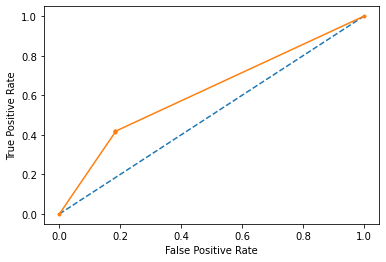

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
pred_test_prob = tree.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))

# Question 3

In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), 
                        n_estimators=100, oob_score = True, random_state=13)
# base estimator is just the estimator model we will use 
    # we used decisiontreeclassifier earlier and will use it here
    # also use becuase decision tree already has very low bias and
    ## the goal of bagging is to reduce variance
# n_estimators is the number of models (trees) we will train
    # aka number of iterations
# oob_score is to use the OOB prediction (default is false)

bag.fit(x_train, y_train.values.ravel())
# use .values.ravel to convert y_train to an array (necesary to run)

pred_train = bag.predict(x_train)
print("Regression Tree Train accuracy:",accuracy_score(pred_train,y_train))
pred_test = bag.predict(x_test)
print("Regression Tree Test accuracy:",accuracy_score(pred_test,y_test))

Regression Tree Train accuracy: 0.9994166666666666
Regression Tree Test accuracy: 0.8171666666666667


In [44]:
cm = confusion_matrix(y_test, pred_test)
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]
print(cm)
print("The FNR is:", FN/(TP+FN))
print("The FPR is:",FP/(FP+TN))
print("The MR is:",(FP + FN)/len(y_test))

[[4425  249]
 [ 848  478]]
The FNR is: 0.3425034387895461
The FPR is: 0.16081926796889817
The MR is: 0.18283333333333332


AUC: 0.7642194134491952


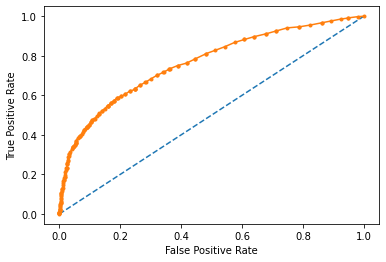

In [45]:
pred_test_prob = bag.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))

# Question 4

In [46]:
import math
p = round(math.sqrt(x_train.shape[1]))
p

5

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators = 100, random_state = 1, max_features = p)
# n_estimators is the number of trees in the forest
# max_features is the number of features to look at when considering each split
    # this is where the Rf model is good, because smaller m decerases correlation
    # default use here is sqrt(p) where p is number of samples
    
rf.fit(x_train, y_train.values.ravel())
pred_train = rf.predict(x_train)
print("Regression Tree Train accuracy:",accuracy_score(pred_train,y_train))
pred_test = rf.predict(x_test)
print("Regression Tree Test accuracy:",accuracy_score(pred_test,y_test))

Regression Tree Train accuracy: 0.9994166666666666
Regression Tree Test accuracy: 0.8183333333333334


In [49]:
cm = confusion_matrix(y_test, pred_test)
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]
print(cm)
print("The FNR is:", FN/(TP+FN))
print("The FPR is:",FP/(FP+TN))
print("The MR is:",(FP + FN)/len(y_test))

[[4431  243]
 [ 847  479]]
The FNR is: 0.3365650969529086
The FPR is: 0.16047745358090185
The MR is: 0.18166666666666667


AUC: 0.7690208534616901


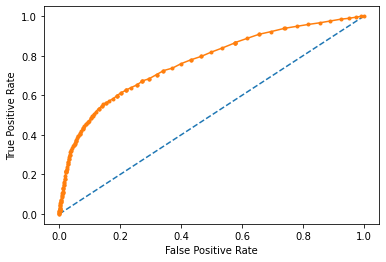

In [50]:
pred_test_prob = rf.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))

# Question 5

<BarContainer object of 29 artists>

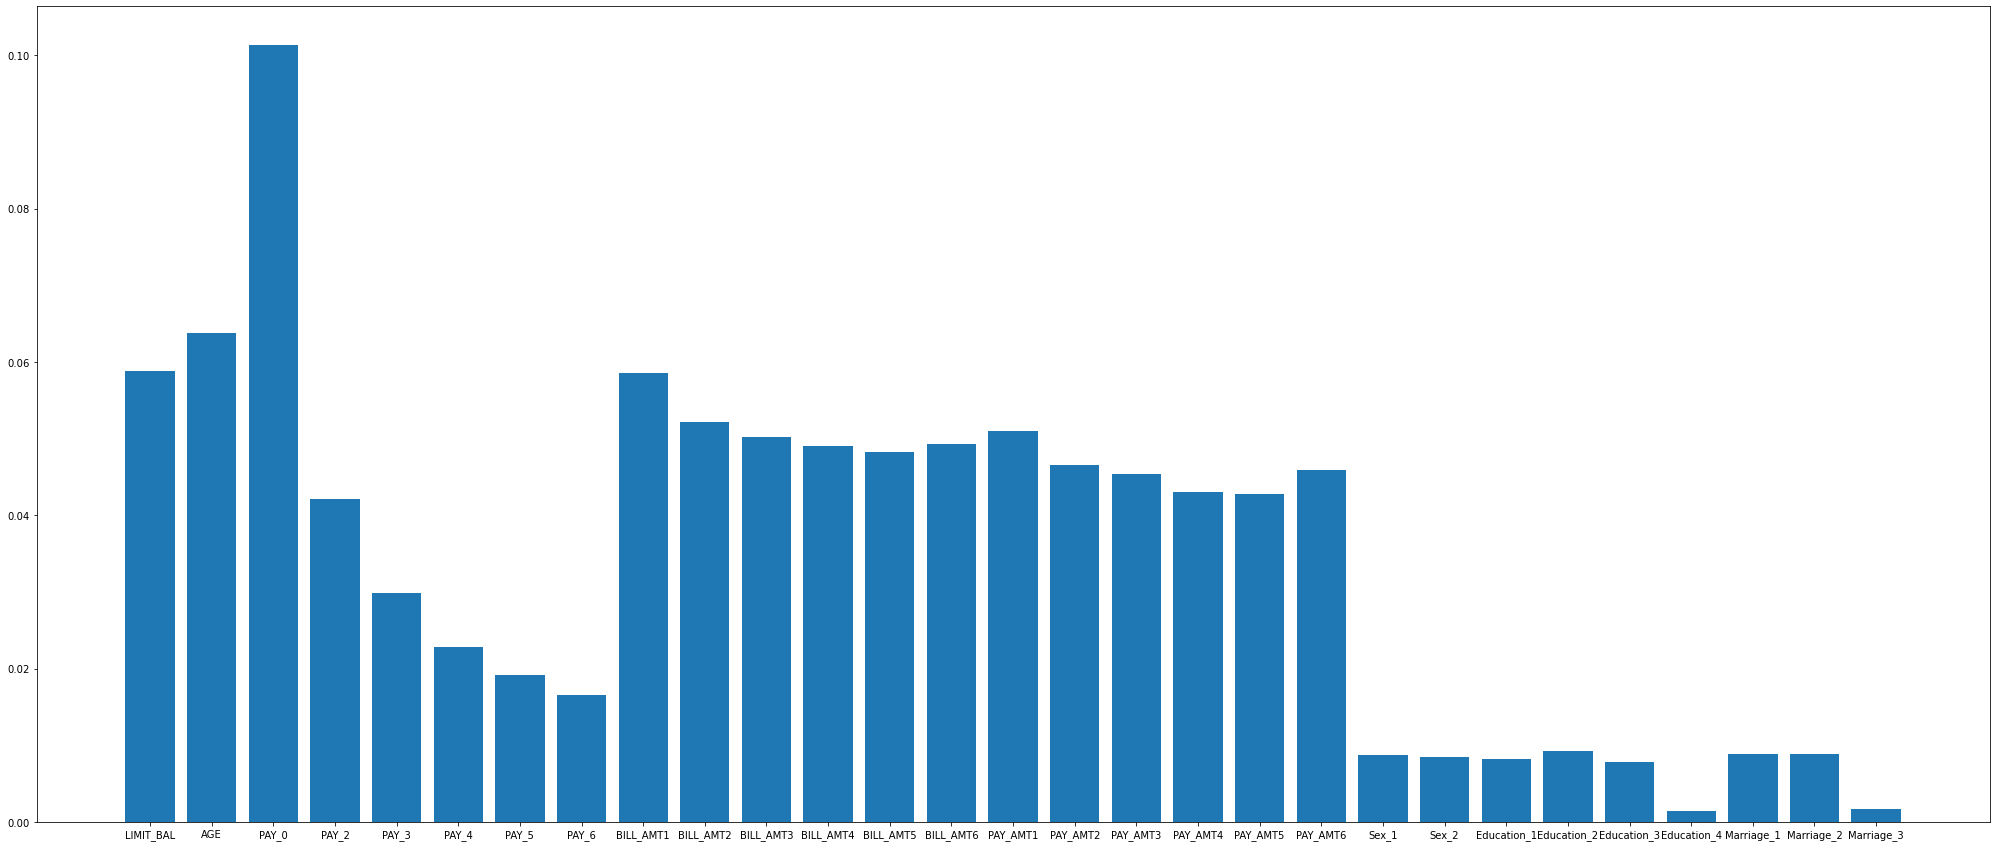

In [53]:
feature_importances = rf.feature_importances_
# feature_importances_ is an output of the RandomForestClassifier function

pd.Series(feature_importances.reshape(x_train.shape[1],), index=default.iloc[:,:-1].columns)

plt.figure(figsize=(35, 15))
plt.bar(default.iloc[:,:-1].columns, feature_importances)
# based on default df which has 23 indp variab and 24th col is depend variab

# Question 6

In [54]:
score = []
for p in range(1,x_train.shape[1]+1):
    rf = RandomForestClassifier(n_estimators = 100, random_state = 1, max_features = p, oob_score= True)
    rf.fit(x_train, y_train.values.ravel())
    pred_train = rf.predict(x_train)
    pred_test = rf.predict(x_test)
    score.append(rf.oob_score_)

Text(0, 0.5, 'OOB score')

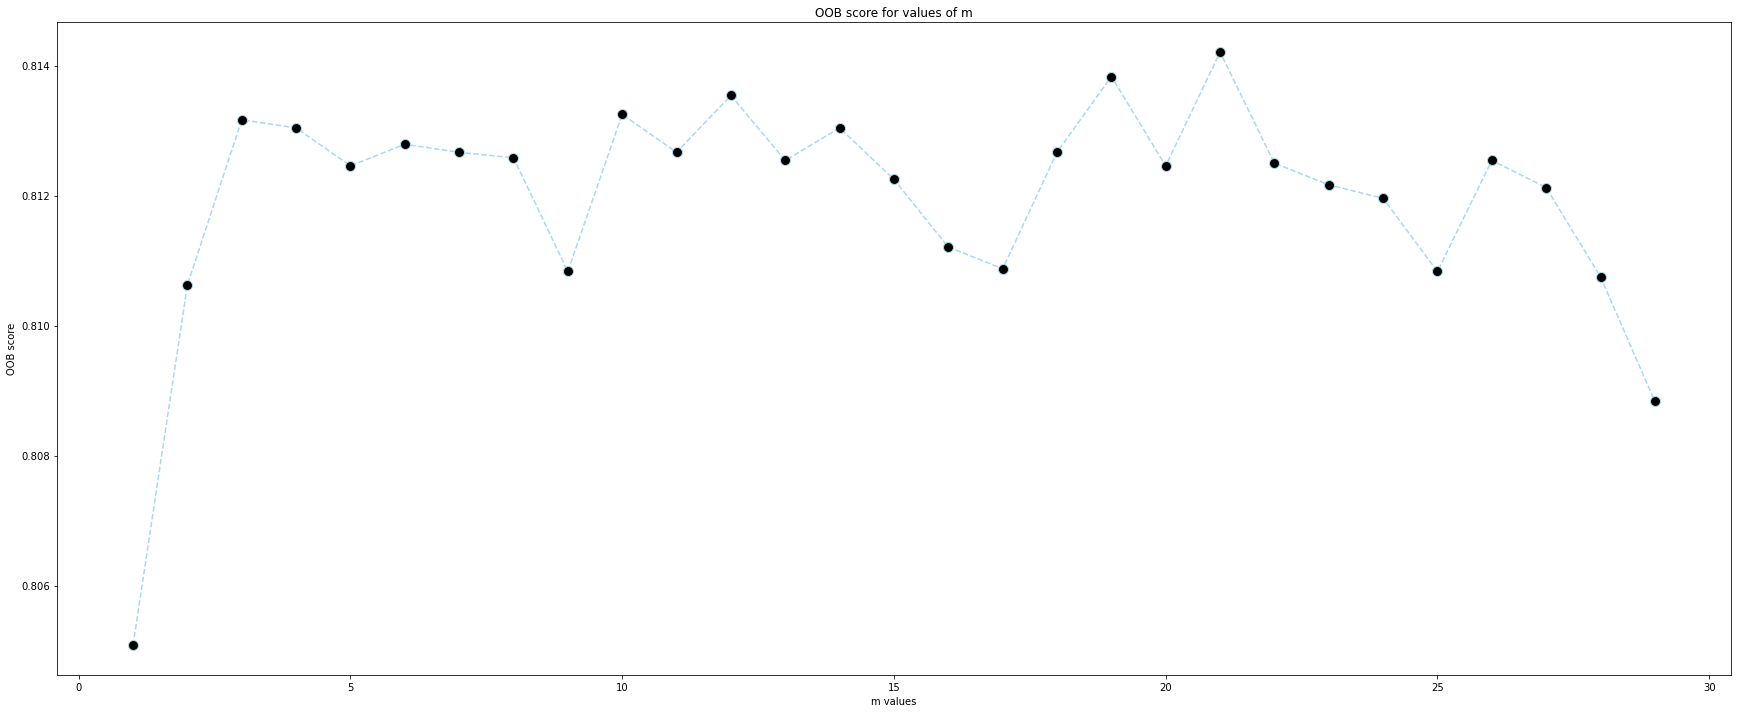

In [55]:
plt.figure(figsize=(30,12))
plt.plot(range(1,x_train.shape[1]+1), score, color='lightblue',
         linestyle='dashed', marker = 'o', 
         markerfacecolor='black', markersize=10)
plt.title('OOB score for values of m')
plt.xlabel('m values')
plt.ylabel('OOB score')

In [56]:
best_oob = max(score)
print("The best OOB score is:",best_oob)
print("The optimal value of m based on OOB score is:",score.index(best_oob)+1)

The best OOB score is: 0.8142083333333333
The optimal value of m based on OOB score is: 21


In [59]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 1, max_features = score.index(best_oob)+1)
rf.fit(x_train, y_train.values.ravel())
pred_train = rf.predict(x_train)
print("Regression Tree Train accuracy:",accuracy_score(pred_train,y_train))
pred_test = rf.predict(x_test)
print("Regression Tree Test accuracy:",accuracy_score(pred_test,y_test))

Regression Tree Train accuracy: 0.9994166666666666
Regression Tree Test accuracy: 0.8185


In [60]:
cm = confusion_matrix(y_test, pred_test)
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]
print(cm)
print("The FNR is:", FN/(TP+FN))
print("The FPR is:",FP/(FP+TN))
print("The MR is:",(FP + FN)/len(y_test))

[[4427  247]
 [ 842  484]]
The FNR is: 0.3378932968536252
The FPR is: 0.159802619092807
The MR is: 0.1815


AUC: 0.7679025397065117


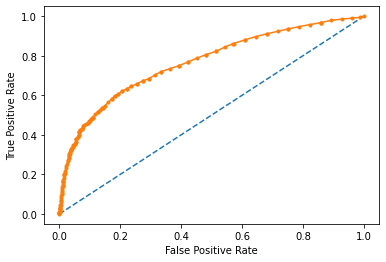

In [61]:
pred_test_prob = rf.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))